In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('survey_results_public.csv').set_index('Respondent')
len(df)

51392

In [31]:
# Narrow down to a few fields of interest and drop empty records since I'm not getting paid for this
df = df[['Country', 'ProgramHobby', 'FormalEducation', 'DeveloperType', 'HaveWorkedLanguage', 'TabsSpaces', 'Currency', 'Salary']].copy()
df = df.dropna()
len(df)

11252

In [4]:
# New features
df['isDataScientist'] = df['DeveloperType'].apply(lambda s: "Data scientist" in s).astype(np.bool)
df['isHobbyist'] = df['ProgramHobby'].apply(lambda s: 'Yes' in s).astype(np.bool)

In [7]:
# Convert currency names to country names in Big Mac Index
#set(df['Currency'])
currencyMap = {
    'Australian dollars (A$)': 'Australia',
    'Brazilian reais (R$)': 'Brazil',
    'British pounds sterling (£)': 'Britain',
    'Canadian dollars (C$)': 'Canada',
    'Chinese yuan renminbi (¥)': 'China',
    'Euros (€)': 'Euro area',
    'Indian rupees (?)': 'India',
    'Japanese yen (¥)': 'Japan',
    'Mexican pesos (MXN$)': 'Mexico',
    'Polish zloty (zl)': 'Poland',
    'Russian rubles (?)': 'Russia',
    'Singapore dollars (S$)': 'Singapore',
    'South African rands (R)': 'South Africa',
    'Swedish kroner (SEK)': 'Sweden',
    'Swiss francs': 'Switzerland',
    'U.S. dollars ($)': 'United States'}
df['currencyRegion'] = df['Currency'].map(currencyMap)

In [8]:
# Read in the big mac index and rename variables
bmi = pd.read_csv('BMFile2000toJul2017.csv')
bmi['currencyRegion'] = bmi['Country']
bmi['bmPrice'] = bmi['local_price']
bmi = bmi[['currencyRegion', 'bmPrice']].copy()

In [10]:
df = df.merge(bmi, on='currencyRegion')

In [11]:
df['realIncome'] = df['Salary'] / df['bmPrice']

In [12]:
df.columns

Index(['Country', 'ProgramHobby', 'FormalEducation', 'DeveloperType',
       'HaveWorkedLanguage', 'TabsSpaces', 'Currency', 'Salary',
       'isDataScientist', 'isHobbyist', 'currencyRegion', 'bmPrice',
       'realIncome'],
      dtype='object')

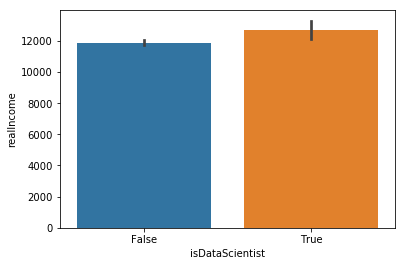

In [13]:
sns.barplot(y='realIncome', x='isDataScientist', data=df)

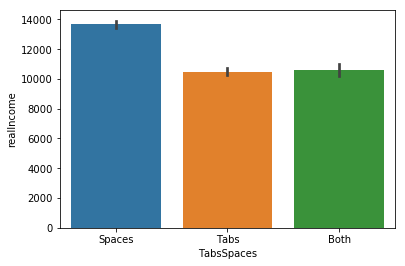

In [14]:
sns.barplot(y='realIncome', x='TabsSpaces', data=df)

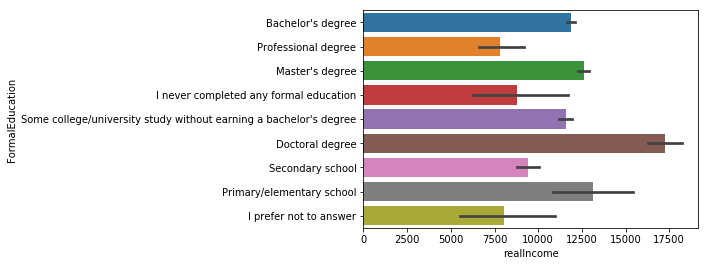

In [15]:
sns.barplot(x='realIncome', y='FormalEducation', data=df)

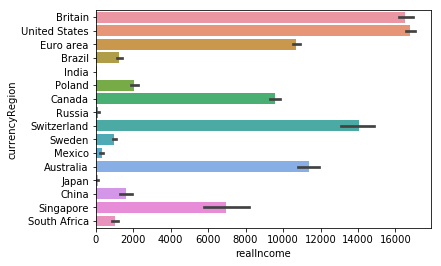

In [16]:
sns.barplot(x='realIncome', y='currencyRegion', data=df)

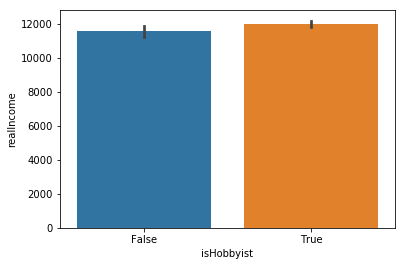

In [17]:
sns.barplot(y='realIncome', x='isHobbyist', data=df)

In [18]:
df.columns

Index(['Country', 'ProgramHobby', 'FormalEducation', 'DeveloperType',
       'HaveWorkedLanguage', 'TabsSpaces', 'Currency', 'Salary',
       'isDataScientist', 'isHobbyist', 'currencyRegion', 'bmPrice',
       'realIncome'],
      dtype='object')

In [19]:
df_train_categorical = df[["FormalEducation", "TabsSpaces", "isHobbyist", "isDataScientist", "currencyRegion"]]
df_train = pd.get_dummies(df_train_categorical)
y_train = df['realIncome']

In [20]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=10, random_state=42, max_iter=2**15)
clf.fit(df_train, y_train)
clf.score(df_train, y_train)

0.49839756204911978

In [21]:
from sklearn.linear_model import ElasticNet
clf = ElasticNet(random_state=42, alpha=10, l1_ratio=1)
clf.fit(df_train, y_train)
clf.score(df_train, y_train)

0.49839756204911978

In [49]:
from statsmodels.regression.linear_model import OLS
model = OLS(y_train, df_train.astype(np.int))
results = model.fit_regularized(alpha=7.5, refit=True)
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             realIncome   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     401.7
Date:                Tue, 31 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:54:06   Log-Likelihood:            -1.1377e+05
No. Observations:               11252   AIC:                         2.276e+05
Df Residuals:                   11224   BIC:                         2.278e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
isHobbyist                                                                          709.1262    143.871      4.929      0.000     427.113     991.139
isDataScientist                                                                            0          0        nan        nan           0           0
FormalEducation_Bachelor's degree                                                  6820.6738    226.857     30.066      0.000    6375.995    7265.353
FormalEducation_Doctoral degree                                                    1.058e+04    426.492     24.796      0.000    9739.305    1.14e+04
FormalEducation_I never completed any formal education                                     0          0        nan        nan           0           0
FormalEducation_I prefer not to answer                                                     0          0        nan        nan           0           0
FormalEducation_Master's degree                                                    8443.2516    251.411     33.583      0.000    7950.442    8936.061
FormalEducation_Primary/elementary school                                          4794.7267    897.218      5.344      0.000    3036.022    6553.431
FormalEducation_Professional degree                                                5560.1837    579.103      9.601      0.000    4425.040    6695.328
FormalEducation_Secondary school                                                   5074.8023    324.281     15.649      0.000    4439.154    5710.450
FormalEducation_Some college/university study without earning a bachelor's degree  6336.1453    256.876     24.666      0.000    5832.624    6839.667
TabsSpaces_Both                                                                            0          0        nan        nan           0           0
TabsSpaces_Spaces                                                                  2308.5231    114.452     20.170      0.000    2084.177    2532.869
TabsSpaces_Tabs                                                                            0          0        nan        nan           0           0
currencyRegion_Australia                                                                   0          0        nan        nan           0           0
currencyRegion_Brazil                                                             -6410.5362    445.836    -14.379      0.000   -7284.453   -5536.619
currencyRegion_Britain                                                             7705.0233    253.615     30.381      0.000    7207.894    8202.153
currencyRegion_Canada                                                              

In [50]:
coefs = pd.DataFrame({"name": df_train.columns, "value": results.params})

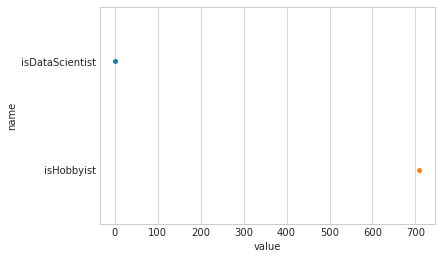

In [51]:
binary_params = coefs[coefs['name'].apply(lambda s: 'is' in s)]
sns.stripplot(x='value', y='name', data=binary_params.sort_values('value'))

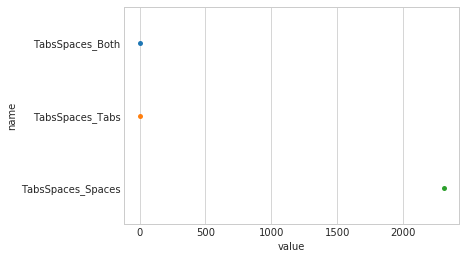

In [52]:
whitespace_params = coefs[coefs['name'].apply(lambda s: 'TabsSpaces' in s)]
sns.stripplot(x='value', y='name', data=whitespace_params.sort_values('value'))

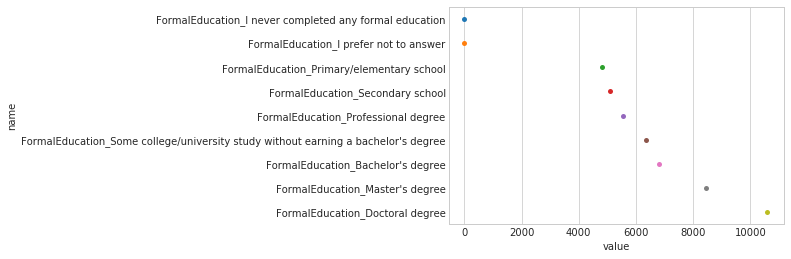

In [53]:
education_params = coefs[coefs['name'].apply(lambda s: 'FormalEducation' in s)]
sns.stripplot(x='value', y='name', data=education_params.sort_values('value'))

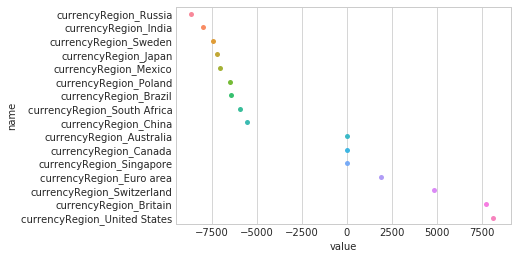

In [54]:
region_params = coefs[coefs['name'].apply(lambda s: 'currencyRegion' in s)]
sns.stripplot(x='value', y='name', data=region_params.sort_values('value'))